In [1]:
import wandb
import numpy as np
import os
from torch import autocast
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import argparse
from sklearn import metrics
from contextlib import nullcontext
import torch.nn as nn
import torch.nn.functional as F
from torch.hub import download_url_to_file

from datasets.audioset import get_test_set, get_full_training_set, get_ft_weighted_sampler
from models.MobileNetV3 import get_model as get_mobilenet, get_ensemble_model
from models.preprocess import AugmentMelSTFT
from helpers.init import worker_init_fn
from helpers.utils import NAME_TO_WIDTH, exp_warmup_linear_down, mixup

from diffeo.transform import Diffeo
%load_ext autoreload
%autoreload 2

parser = argparse.ArgumentParser(description='Example of parser. ')

# general
parser.add_argument('--experiment_name', type=str, default="AudioSet")
parser.add_argument('--train', action='store_true', default=False)
parser.add_argument('--cuda', action='store_true', default=False)
parser.add_argument('--batch_size', type=int, default=120)
parser.add_argument('--num_workers', type=int, default=12)

# evaluation
# overwrite 'pretrained_name' by 'ensemble' to evaluate an ensemble
parser.add_argument('--ensemble', nargs='+', default=[])
parser.add_argument('--model_name', type=str, default="mn10_as")

# training
parser.add_argument('--pretrained_name', type=str, default=None)
parser.add_argument('--model_width', type=float, default=1.0)
parser.add_argument('--strides', nargs=4, default=[2, 2, 2, 2], type=int)
parser.add_argument('--head_type', type=str, default="mlp")
parser.add_argument('--se_dims', type=str, default="c")
parser.add_argument('--n_epochs', type=int, default=200)
parser.add_argument('--mixup_alpha', type=float, default=0.3)
parser.add_argument('--epoch_len', type=int, default=100000)
parser.add_argument('--roll', action='store_true', default=False)
parser.add_argument('--wavmix', action='store_true', default=False)
parser.add_argument('--gain_augment', type=int, default=0)

# lr schedule
parser.add_argument('--max_lr', type=float, default=0.0008)
parser.add_argument('--warm_up_len', type=int, default=8)
parser.add_argument('--ramp_down_start', type=int, default=80)
parser.add_argument('--ramp_down_len', type=int, default=95)
parser.add_argument('--last_lr_value', type=float, default=0.01)

# knowledge distillation
parser.add_argument('--teacher_preds', type=str,
                    default=os.path.join("resources", "passt_enemble_logits_mAP_495.npy"))
parser.add_argument('--temperature', type=float, default=1)
parser.add_argument('--kd_lambda', type=float, default=0.1)

# preprocessing
parser.add_argument('--resample_rate', type=int, default=32000)
parser.add_argument('--window_size', type=int, default=800)
parser.add_argument('--hop_size', type=int, default=320)
parser.add_argument('--n_fft', type=int, default=1024)
parser.add_argument('--n_mels', type=int, default=128)
parser.add_argument('--freqm', type=int, default=0)
parser.add_argument('--timem', type=int, default=0)
parser.add_argument('--fmin', type=int, default=0)
parser.add_argument('--fmax', type=int, default=None)

# Diffeo

args = parser.parse_args(args=[])

In [2]:
def _mel_forward(x, mel):
    old_shape = x.size()
    x = x.reshape(-1, old_shape[2])
    x = mel(x)
    x = x.reshape(old_shape[0], old_shape[1], x.shape[1], x.shape[2])
    return x

In [3]:
model_name = args.model_name
device = torch.device('cuda') if args.cuda and torch.cuda.is_available() else torch.device('cpu')

model = get_mobilenet(width_mult=NAME_TO_WIDTH(model_name), pretrained_name=model_name)
model.to(device)
model.eval()

# model to preprocess waveform into mel spectrograms
mel = AugmentMelSTFT(n_mels=args.n_mels,
                     sr=args.resample_rate,
                     win_length=args.window_size,
                     hopsize=args.hop_size,
                     n_fft=args.n_fft,
                     fmin=args.fmin,
                     fmax=args.fmax
                     )
mel.to(device)
mel.eval()

dl = DataLoader(dataset=get_test_set(resample_rate=args.resample_rate),
                worker_init_fn=worker_init_fn,
                num_workers=args.num_workers,
                batch_size=args.batch_size)


MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

/home/chiche/miniconda3/envs/dcase/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [4]:
import librosa
import librosa.display
from matplotlib import pyplot as plt

In [5]:
def plot_spectrogram(specgram_og, specgram_diffeo, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 2, figsize=(20, 4))
    for i in range(2):
        axs[i].set_ylabel(ylabel)
        axs[i].set_xlabel("frame")
    axs[0].set_title("Original")
    axs[1].set_title("Diffeo")
    im0 = axs[0].imshow(librosa.power_to_db(specgram_og), origin="lower", aspect="auto")
    im1 = axs[1].imshow(librosa.power_to_db(specgram_diffeo), origin="lower", aspect="auto")
    fig.colorbar(im1, ax=axs)
    plt.show(block=False)

In [65]:


#########
diff = Diffeo(sT, rT, scut, rcut, cutmin, cutmax, axis=[0])
##########

TypeError: Diffeo.__init__() got multiple values for argument 'axis'

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.STL10('../CIFAR_data', 
                                                          download=True, 
                                                          split="test",
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                          ])), 
                                           batch_size=10, 
                                           shuffle=True)

Files already downloaded and verified


 w:96, h:96, cut:20
w e: torch.Size([20, 20]), s torch.Size([96, 20])
h e: torch.Size([20, 20]), s torch.Size([96, 20])
c torch.Size([20, 20])
u torch.Size([96, 96])
 w:96, h:96, cut:20
w e: torch.Size([20, 20]), s torch.Size([96, 20])
h e: torch.Size([20, 20]), s torch.Size([96, 20])
c torch.Size([20, 20])
v torch.Size([96, 96])
torch.Size([10, 3, 96, 96])


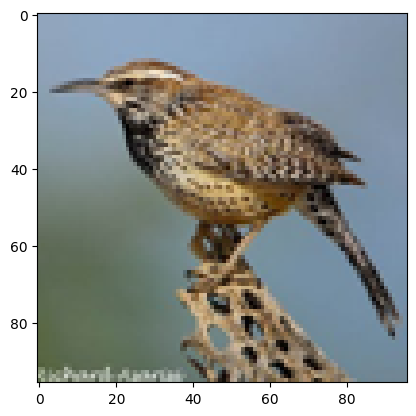

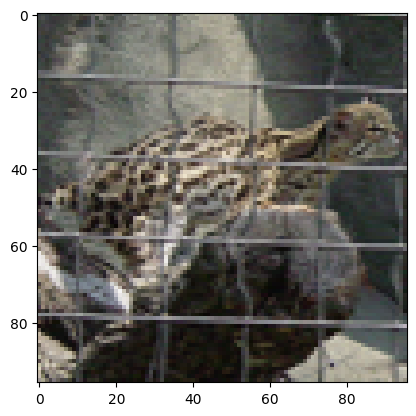

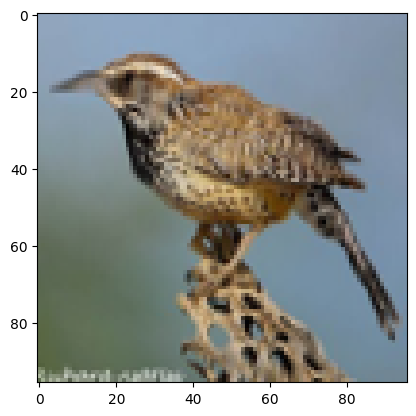

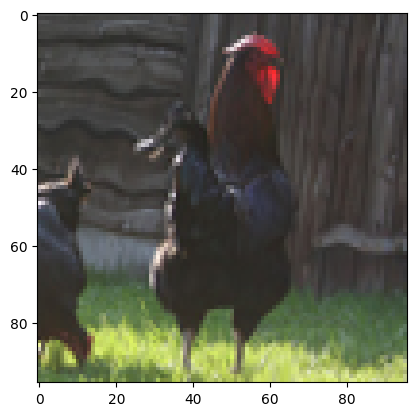

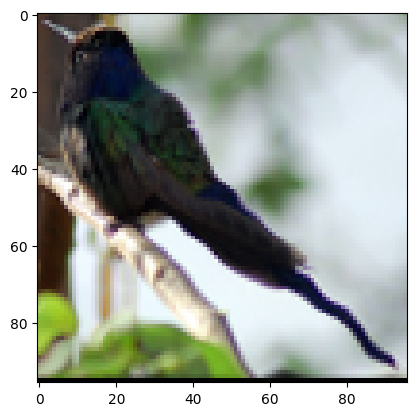

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


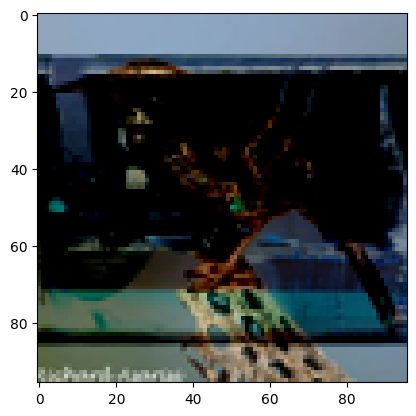

In [78]:
max_batches = 1
for idx, batch in enumerate(train_loader):
    if idx>max_batches-1:
        break
    x, y = batch
    #dx = diff(x[0].permute(0,2,1)).squeeze().numpy().transpose(2,1,0)
    dy = diff(x)
    print(dy.shape)
    plt.imshow(x[0].squeeze().numpy().transpose(1,2,0))
    plt.show()
    plt.imshow(dx)
    plt.show()
    plt.imshow(dy[0].squeeze().numpy().transpose(1,2,0))
    plt.show()
    plt.imshow(dy[1].squeeze().numpy().transpose(1,2,0))
    plt.show()
    plt.imshow(dy[2].squeeze().numpy().transpose(1,2,0))
    plt.show()
    plt.imshow(x[0].squeeze().numpy().transpose(1,2,0)-d)
    plt.show()    

In [38]:
grilla = x[0]

 w:96, h:96, cut:20
w e: torch.Size([20, 20]), s torch.Size([96, 20])
h e: torch.Size([20, 20]), s torch.Size([96, 20])
c torch.Size([20, 20])
u torch.Size([96, 96])
 w:96, h:96, cut:20
w e: torch.Size([20, 20]), s torch.Size([96, 20])
h e: torch.Size([20, 20]), s torch.Size([96, 20])
c torch.Size([20, 20])
v torch.Size([96, 96])
 w:96, h:96, cut:20
w e: torch.Size([20, 20]), s torch.Size([96, 20])
h e: torch.Size([20, 20]), s torch.Size([96, 20])
c torch.Size([20, 20])
u torch.Size([96, 96])
 w:96, h:96, cut:20
w e: torch.Size([20, 20]), s torch.Size([96, 20])
h e: torch.Size([20, 20]), s torch.Size([96, 20])
c torch.Size([20, 20])
v torch.Size([96, 96])


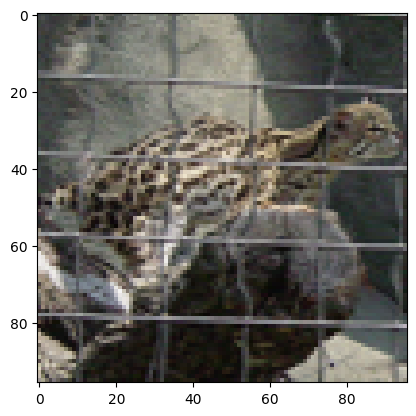

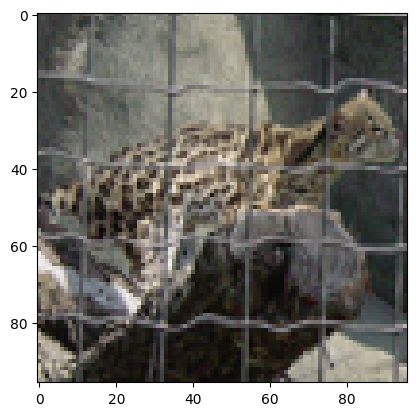

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


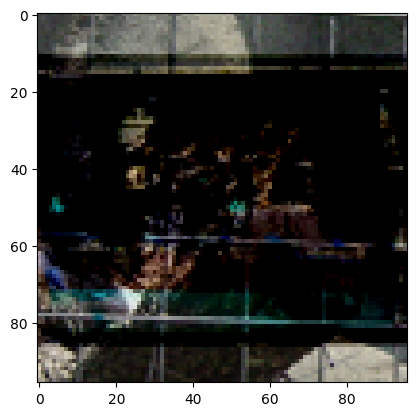

In [75]:
sT = 0.0000000000001
rT = 0.1
scut = 0.0000000000001
rcut = 10
cutmin = 0
cutmax = 20
diff = Diffeo(cutmax, 1.0, axis=[0])
dx = diff(grilla).squeeze().numpy().transpose(1,2,0)
diff = Diffeo(cutmax, 1.0, axis=[1])
dy = diff(grilla).squeeze().numpy().transpose(1,2,0)
plt.imshow(dx)
plt.show()
plt.imshow(dy)
plt.show()
plt.imshow(grilla.squeeze().numpy().transpose(1,2,0)-d)
plt.show()    

 w:1000, h:128, cut:20
w e: torch.Size([20, 20]), s torch.Size([1000, 20])
h e: torch.Size([20, 20]), s torch.Size([128, 20])
c torch.Size([20, 20])
u torch.Size([128, 1000])
 w:1000, h:128, cut:20
w e: torch.Size([20, 20]), s torch.Size([1000, 20])
h e: torch.Size([20, 20]), s torch.Size([128, 20])
c torch.Size([20, 20])
v torch.Size([128, 1000])
13024.907
 w:1000, h:128, cut:20
w e: torch.Size([20, 20]), s torch.Size([1000, 20])
h e: torch.Size([20, 20]), s torch.Size([128, 20])
c torch.Size([20, 20])
u torch.Size([128, 1000])
 w:1000, h:128, cut:20
w e: torch.Size([20, 20]), s torch.Size([1000, 20])
h e: torch.Size([20, 20]), s torch.Size([128, 20])
c torch.Size([20, 20])
v torch.Size([128, 1000])


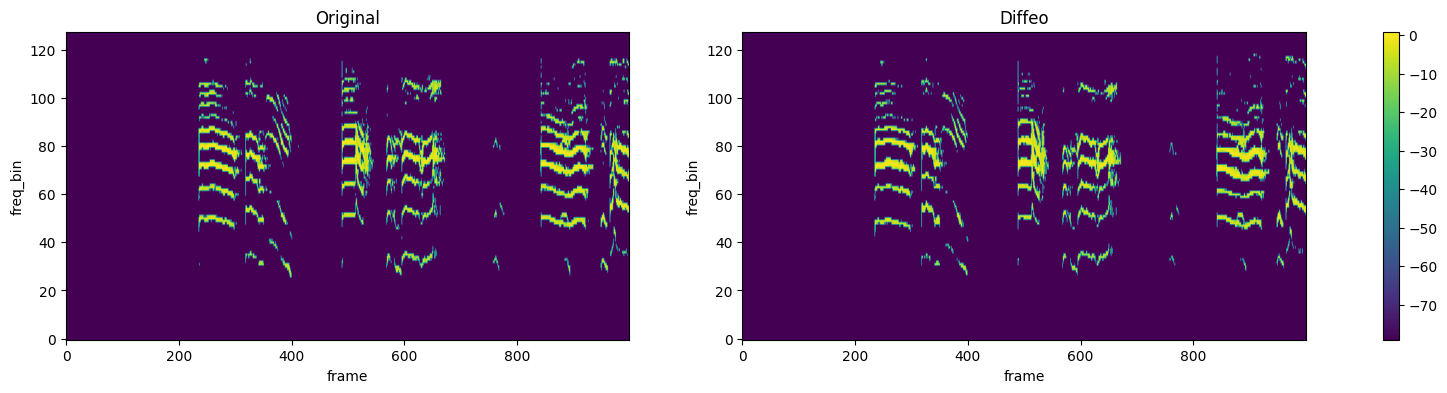

In [79]:
max_batches = 1
for idx, batch in enumerate(dl):
    if idx>max_batches-1:
        break
    x, _, y = batch
    x = x.to(device)
    y = y.to(device)
    # our models are trained in half precision mode (torch.float16)
    # run on cuda with torch.float16 to get the best performance
    # running on cpu with torch.float32 gives similar performance, using torch.bfloat16 is worse
    with autocast(device_type=device.type) if args.cuda else nullcontext():
        with torch.no_grad():
            x = _mel_forward(x, mel)
            print(np.sum((x[0].squeeze().numpy()-diff(x[0].squeeze()).numpy())**2))
            plot_spectrogram(x[0].squeeze().numpy(),diff(x[0].squeeze()).numpy(),  ylabel="freq_bin")
            

In [80]:
x.shape

torch.Size([9, 1, 128, 1000])